# Flood  - Classification - ML Models

<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 07/25/2016 <br/>
</h3>

# Script Setup

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio

from flood_functions import grace_brick_convert_lowres 
from flood_functions import calculate_confusion_matrix_bricks
from flood_functions import calculate_ml_metric_maps
from IPython.display import display, HTML

from scipy import interp



from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [8]:
%pylab inline
#%matplotlib

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
# define directories
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

# Load Data

## GRACE

In [10]:
# feature bricks
f = open(dir_python_data+'grace_features_lowres.p', 'rb')
grace_features_dict = pickle.load(f)
f.close()

# alter shape
feature_lwe_rank =\
    np.flipud(grace_features_dict['grace_lwe_rank_lowres'].transpose(1,0,2))
feature_lwe_noClim_rank =\
    np.flipud(grace_features_dict['grace_lwe_noClim_rank_lowres'].transpose(1,0,2))
feature_lwe_clim_rank =\
    np.flipud(grace_features_dict['grace_lwe_clim_rank_lowres'].transpose(1,0,2))
    
print"GRACE Feature Brick Shape:", feature_lwe_rank.shape

GRACE Feature Brick Shape: (60, 120, 152)


## Flood Observatory

In [11]:
# flood event brick
f = open(dir_python_data+'flood_event_brick_lowres.p', 'rb')
flood_event_brick = pickle.load(f)
f.close()

# alter shape
flood_event_brick = flood_event_brick[0]
flood_event_brick = np.flipud(flood_event_brick.transpose(1,0,2))
print "Flood Event Brick Shape:",flood_event_brick.shape

Flood Event Brick Shape: (60, 120, 152)


In [12]:
# flood dataframe
df_name = 'df_flood_grace_time_location_features'
df_flood_grace = pd.read_csv(dir_python_data + df_name + '.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)
print "Flood Dataframe Shape:", df_flood_grace.shape

Flood Dataframe Shape: (1977, 41)


# Script Variables

In [13]:
# GRACE
dim = feature_lwe_rank.shape
d1 = dim[0]
d2 = dim[1]
tp = dim[2]

# FO
floods = len(df_flood_grace)

# ML Setup

## Create Labels

In [14]:
label_brick = flood_event_brick
y_labels = label_brick.ravel()

# mask out regions without flood events
mask = ~np.isnan(y_labels)
y_labels = y_labels[mask]
y = y_labels

## Create Features

In [15]:
# convert to percentiles
feature_lwe_perc =\
    ((feature_lwe_rank/tp)*100).ravel()
feature_lwe_noClim_perc =\
    ((feature_lwe_noClim_rank/tp)*100).ravel()
feature_lwe_clim_perc =\
    ((feature_lwe_clim_rank/tp)*100).ravel()
    
# create feature matrix
#X_features =\
#    np.vstack((feature_lwe_perc, feature_lwe_noClim_perc, feature_lwe_clim_perc))

X_features =\
    np.vstack((feature_lwe_perc, feature_lwe_noClim_perc, feature_lwe_clim_perc))
    
X_features = X_features.transpose()
X = X_features

In [16]:
# mask out regions without flood events
feature_lwe_perc = feature_lwe_perc[mask]
feature_lwe_noClim_perc = feature_lwe_noClim_perc[mask]
feature_lwe_clim_perc = feature_lwe_clim_perc[mask]


In [17]:
# create feature matrix
X_features =\
    np.vstack((feature_lwe_perc,
               #feature_lwe_noClim_perc, 
               #feature_lwe_clim_perc * feature_lwe_noClim_perc
               feature_lwe_clim_perc
               ))
    
X_features = X_features.transpose()
X = X_features

## Train-Test Split

In [18]:
idx_split = int(round(y.shape[0] * 0.7) -1)

X_train = X[0:idx_split,:]
X_test = X[idx_split:-1,:]

y_train = y[0:idx_split]
y_test = y[idx_split:-1]

print "Length of Training Set: ",len(y_train)
print "Length of Testing Set: ",len(y_test)

Length of Training Set:  63733
Length of Testing Set:  27314


# Classification

## Linear SVC

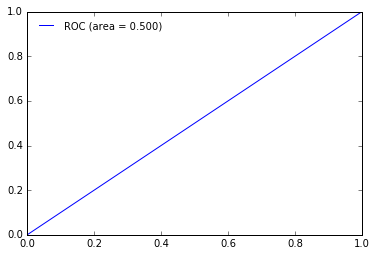

In [23]:
# fit and predict
clf = LinearSVC()
clf.fit(X_train, y_train)
y_scores = clf.predict(X_test)

# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.show()

## Logistic Regression

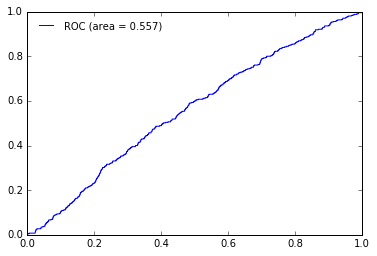

In [185]:
# fit and predict
clf = LogisticRegression(C=100)
clf.fit(X_train, y_train)
probas_ = clf.predict_proba(X_test)
y_scores = probas_[:,1]

# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.show()

In [186]:
clf.coef_

array([[ 0.00665186,  0.06772757]])

## Single Decision Tree

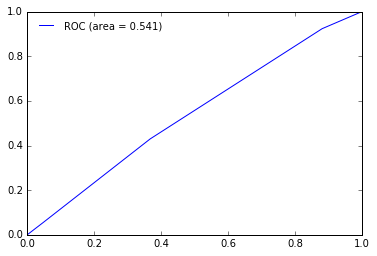

In [144]:
clf = DecisionTreeClassifier(max_depth=2,
                             min_samples_split=400)

probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
y_scores = probas_[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.show()

In [145]:
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, filled=True, rounded=True, 
                             impurity=False, proportion=True,
                             feature_names=['lwe perc','lwe no-clim perc','lwe clim'])

# terminal command to create pdf
# dot -Tpdf tree.dot -o tree.pdf

IndexError: list index out of range

## Random Forest Analysis

In [146]:
clf = RandomForestClassifier(n_estimators = 100,
                             max_depth=2,
                             min_samples_split=400)

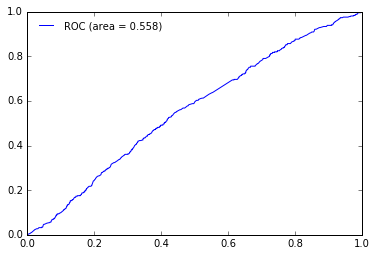

In [147]:
# fit and predict
probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
y_scores = probas_[:,1]

# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 'b', label='ROC (area = %0.3f)' % roc_auc)

plt.legend(loc='upper left', fontsize='medium', frameon=False)
plt.show()

In [112]:
X_train

array([[ 78.81578947,  47.89473684,   6.57894737],
       [ 92.5       ,  58.94736842,   7.63157895],
       [  3.94736842,   6.44736842,   2.36842105],
       ..., 
       [ 65.35087719,  62.71929825,   4.8245614 ],
       [ 62.28070175,  68.85964912,   3.50877193],
       [ 55.48245614,  77.19298246,   1.31578947]])